**Aluno:** Alexandre Esposte Santos

**Data:** 27/09/2023

**Atividade:** Tarefa 2 - Formation Energy Regression

**Demandas / Objetivos:**

This project aim is to obtain an regression model for the formation energy of 2D materials.

Please used the Ridge and Lasso regressions in this problem. In general we want the model to as simple as possible, so
remove non-important features.

The target is given by the "hform" column. The first column (Material) is just a label.

The second column gives the Space Group of a given material. Note, some materials have the same
chemical formula and the Space Group (which is intimate related to the original prototype) will discriminate the material.

All other ones a features which we believe can describe our problem.

**Referências**

1. [Numpy](https://numpy.org/doc/stable/reference/index.html#reference) 

2. [Pandas](https://pandas.pydata.org/docs/reference/index.html) 

3. [Seaborn](https://seaborn.pydata.org/api.html) 

4. [Matplotlib](https://matplotlib.org/stable/api/index.html)

5. [Scikit-Learn](https://scikit-learn.org/stable/modules/classes.html)

6. [Category Encoders](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)

In [103]:
import pandas                           as pd
import numpy                            as np
import matplotlib.pyplot                as plt
import seaborn                          as sns
from sklearn.linear_model               import LinearRegression, Lasso, Ridge
from sklearn.model_selection            import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute                     import KNNImputer
from sklearn.preprocessing              import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline                   import Pipeline
from sklearn.metrics                    import mean_squared_error, mean_absolute_error
from sklearn.compose                    import ColumnTransformer
from category_encoders.target_encoder   import TargetEncoder


import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

## Funções

In [104]:
def init_model(alpha_lasso: float = 1, alpha_ridge: float = 1, x_train=None, imputer=None, encoder=None, scaler=None) -> dict:
    
    var_categoricos = x_train.select_dtypes('object').columns.tolist()
    var_num = x_train.select_dtypes(exclude='object').columns.tolist()
 
    numeric_pipe = Pipeline(steps = [('imputer',imputer),('scaler',scaler)])

    categorical_pipe = Pipeline(steps = [('encoder',encoder)])

    preprocessing = ColumnTransformer([('categorico',categorical_pipe,var_categoricos),('numerico',numeric_pipe,var_num)] ,remainder='passthrough')


    lreg_step = [('preprocessing',preprocessing),('model',LinearRegression())]
    lreg = Pipeline(steps=lreg_step)

    lasso_step = [('preprocessing',preprocessing),('model',Lasso(alpha=alpha_lasso,max_iter=100000))]
    lasso = Pipeline(steps=lasso_step)

    ridge_step = [('preprocessing',preprocessing),('model',Ridge(alpha= alpha_ridge))]
    ridge = Pipeline(steps=ridge_step)



    modelos = {'linear': lreg,
            'lasso':lasso,
            'ridge':ridge}
    return modelos

In [105]:
def validacao_cruzada(modelos: dict, x_train: pd.DataFrame, y_train: pd.DataFrame) -> pd.DataFrame:
    
    metricas = {'modelos':[],'media':[],'std':[]}
    for i in modelos.items():
        model_name = i[0]
        model = i[1]
        print(f"----- {model_name} ----")
        score = cross_val_score(model,x_train,y_train,scoring='neg_root_mean_squared_error')
        print(f"\t-> Rms em cada fold: {-1*score}\n")

        metricas['modelos'].append(model_name)
        metricas['media'].append(-1*score.mean())
        metricas['std'].append(score.std())
    

    return pd.DataFrame(metricas,index=metricas['modelos'])

In [106]:
def treinar(modelos: dict, x_train: pd.DataFrame , y_train: pd.DataFrame, x_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    resultados = {'modelos':[],'rmse_treino':[],'rmse_teste':[],'mae_treino':[],'mae_teste':[]}
    for i in modelos.items():
        model_name = i[0]
        model = i[1]
        print(f"----- {model_name} ----")
        model.fit(x_train,y_train)

        err_train = mean_squared_error(y_train,model.predict(x_train),squared=False)
        err_test = mean_squared_error(y_test,model.predict(x_test),squared=False)
        
        resultados['modelos'].append(model_name)
        resultados['rmse_treino'].append(err_train)
        resultados['rmse_teste'].append(err_test)

        err_train = mean_absolute_error(y_train,model.predict(x_train))
        err_test = mean_absolute_error(y_test,model.predict(x_test))
        resultados['mae_treino'].append(err_train)
        resultados['mae_teste'].append(err_test)
    

    return pd.DataFrame(resultados,index=resultados['modelos'])


In [107]:
def tunning(modelos: dict, grade_de_parametros: list, x_train: pd.DataFrame, y_train: pd.DataFrame, qte_buscas: int) -> None:
    for i in modelos.items():
        model_name = i[0]
        model = i[1]
        if model_name in ['linear']:
            continue
        print(f"----- {model_name} ----")

        forca_bruta = RandomizedSearchCV(model,param_distributions= grade_de_parametros,cv = 5,n_iter= qte_buscas,n_jobs = -1,scoring='neg_root_mean_squared_error')
        forca_bruta.fit(x_train,y_train)

        print(f"Melhor parâmetro: {forca_bruta.best_params_}")
        print(f"Melhor Rmse: {-1*forca_bruta.best_score_}")

## Inicio

In [108]:
arq = "../datasets/AB2_formation_energy_materials_spacegroup.csv"

data = pd.read_csv(arq, index_col ='Unnamed: 0' )

In [109]:
data.head()

,Material,Space Group,hform,Z_x,Electronegativity_x,IonizationPotential_x,ElectronAffinity_x,HOMO_x,LUMO_x,r_s_orbital_x,...,r_p_orbital_y,r_d_orbital_y,r_atomic_nonbonded_y,r_valence_lastorbital_y,r_covalent_y,Valence_y,PeriodicColumn_y,PeriodicColumn_upto18_y,NumberUnfilledOrbitals_y,Polarizability_y
0,AgBr2,P-4m2,-0.132046,47,1.93,-7.8182,-1.2721,-4.4022,0.9657,1.3241,...,0.8834,0.2281,1.14,0.8834,1.2,17.0,7.0,17.0,1.0,21.8
1,AlBr2,P-3m1,-0.586257,13,1.61,-5.7176,0.0364,-2.7120,3.1169,1.1043,...,0.8834,0.2281,1.14,0.8834,1.2,17.0,7.0,17.0,1.0,21.8
2,AsBr2,P-6m2,0.082309,33,2.18,-9.0974,-1.6025,-5.1964,4.1976,0.8558,...,0.8834,0.2281,1.14,0.8834,1.2,17.0,7.0,17.0,1.0,21.8
3,AsBr2,P-3m1,0.192804,33,2.18,-9.0974,-1.6025,-5.1964,4.1976,0.8558,...,0.8834,0.2281,1.14,0.8834,1.2,17.0,7.0,17.0,1.0,21.8
4,AuBr2,P-4m2,0.025653,79,2.54,-9.3842,-2.3142,-5.7531,0.7024,1.2274,...,0.8834,0.2281,1.14,0.8834,1.2,17.0,7.0,17.0,1.0,21.8


In [110]:
print(f"Quantidade de linhas : {data.shape[0]} || Quantidade de colunas: {data.shape[1]}")

Quantidade de linhas : 625 || Quantidade de colunas: 37


**Verificando linhas duplicadas**

Não há entradas duplicadas

In [111]:
data.duplicated().sum()

0

**Verificando dados faltantes:**

Observamos que as variáveis "r_p_orbital_y" e "r_d_orbital_y" contém 19 valores faltantes. Totalizando assim em 38 valores nulos na nossa base

In [112]:
data.isna().sum().to_frame(name='Qte_faltantes').query('Qte_faltantes > 0 ')

,Qte_faltantes
r_p_orbital_y,19
r_d_orbital_y,19


Observamos que todos os valores nulos estão presentes no grupo espacial "P-6m2". O fato desse grupo ter essas variáveis nulas pode indicar uma propriedade especifica de um dado material, entretanto, não é possível tirar conclusões definitivas sem entender o contexto em que estamos lidando. 

É possível realizar três tratativas:

1. Remover as 38 linhas e assumir uma a perca de informação.

2. Utilizar algum método para preencher os valores nulos.

3. Preencher com um valor especifico qualquer, dessa forma o modelo pode aprender que existe algum padrão relacionado a esses dados faltantes.



A seguir as instâncias com os valores faltantes

In [113]:
data[data[['r_p_orbital_y','r_d_orbital_y']].isna().any(axis=1) == True]

,Material,Space Group,hform,Z_x,Electronegativity_x,IonizationPotential_x,ElectronAffinity_x,HOMO_x,LUMO_x,r_s_orbital_x,...,r_p_orbital_y,r_d_orbital_y,r_atomic_nonbonded_y,r_valence_lastorbital_y,r_covalent_y,Valence_y,PeriodicColumn_y,PeriodicColumn_upto18_y,NumberUnfilledOrbitals_y,Polarizability_y
352,AgH2,P-6m2,0.521015,47,1.93,-7.8182,-1.2721,-4.4022,0.9657,1.3241,...,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107
353,AuH2,P-6m2,0.565379,79,2.54,-9.3842,-2.3142,-5.7531,0.7024,1.2274,...,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107
354,CuH2,P-6m2,0.324558,29,1.90,-8.2910,-1.4328,-4.6082,1.3569,1.2022,...,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107
355,HfH2,P-6m2,-0.046680,72,1.30,-6.4985,0.7772,-2.6937,-0.4781,1.5366,...,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107
356,IrH2,P-6m2,0.186759,77,2.20,-8.8201,-2.5410,-5.6901,0.5069,0.9966,...,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107
357,MoH2,P-6m2,0.315933,42,2.16,-6.8668,-1.5561,-4.3183,-0.1345,1.5418,...,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107
358,NbH2,P-6m2,0.140058,41,1.60,-7.1783,-0.8556,-4.6186,-0.7269,1.5752,...,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107
359,NiH2,P-6m2,0.073967,28,1.91,-7.5452,-1.2886,-4.3916,0.5082,1.2589,...,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107
360,OsH2,P-6m2,0.420154,76,2.20,-9.1155,-1.8446,-6.0059,-0.0685,1.3156,...,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107
361,PtH2,P-6m2,0.166854,78,2.28,-9.1302,-2.2143,-5.3120,0.8213,0.9879,...,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107


Há 314 materiais e 7 grupos espaciais

In [114]:
data['Material'].nunique(), data['Space Group'].nunique()

(314, 7)

**Os grupos presentes são:**
* 'P-4m2' - Este grupo espacial pertence à classe Tetragonal.

* 'P-3m1' - Este grupo espacial pertence à classe Trigonal.
 
* 'P-6m2' - Este grupo espacial pertence à classe Hexagonal.
 
* 'Pmm2' - Este grupo espacial pertence à classe Ortorrômbica.
 
* 'P1' - Este grupo espacial pertence à classe Triclínica.
 
* 'P-1' - Este grupo espacial também pertence à classe Triclínica.
 
* 'Cmmm' - Este grupo espacial pertence à classe Ortorrômbica.

Aparentemente há um erro, notamos que P1 e P-1 representam a mesma classe.

Não vou tratar essa classe pois, como podemos visualizar a seguir, só há 3 instancias em todo o dataset.

In [115]:
print(data['Space Group'].unique())

['P-4m2' 'P-3m1' 'P-6m2' 'Pmm2' 'P1' 'P-1' 'Cmmm']


,qte,qte(%)
Space Group,,
P-4m2,225,36.00
P-6m2,197,31.52
P-3m1,192,30.72
Pmm2,7,1.12
P-1,2,0.32
Cmmm,1,0.16
P1,1,0.16


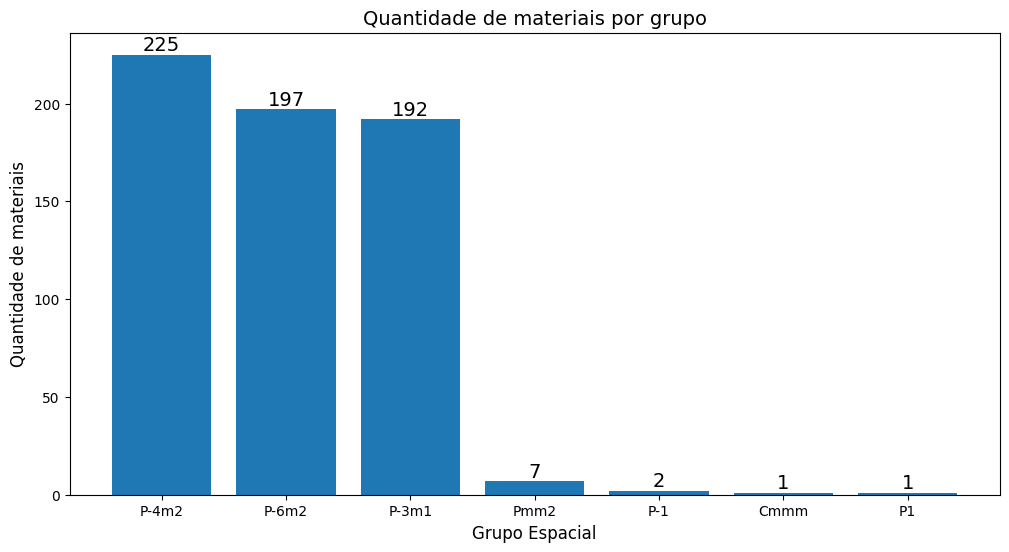

In [116]:
grupos_qte = data.groupby('Space Group').size().to_frame(name='qte').sort_values(by='qte',ascending=False)
grupos_qte['qte(%)']= grupos_qte['qte']/grupos_qte['qte'].sum()*100
display(grupos_qte)

plt.figure(figsize=(12,6))
_ = plt.bar(x = grupos_qte.index, height= grupos_qte['qte'])
plt.xlabel('Grupo Espacial',size=12)
plt.ylabel('Quantidade de materiais',size=12)
plt.title("Quantidade de materiais por grupo",size=14)

for grupo in grupos_qte.index:
    plt.text(grupo,grupos_qte.loc[grupo,'qte'],str(grupos_qte.loc[grupo,'qte']),ha= 'center',va='bottom',size=14)
    

Vamos remover as classes com poucos materiais.

In [117]:
data.shape

(625, 37)

In [118]:
remover = grupos_qte[grupos_qte['qte'] < 10].index.tolist()
data['remover'] = data['Space Group'].apply(lambda x: x in remover)
idx = data.query('remover == True').index

data = data.drop(idx)
data = data.drop('remover',axis=1)

data.shape

(614, 37)

## **Iniciando a modelagem**

Os modelos utilizados estão listados a seguir,

* Linear Regression

* Lasso

* Ridge

**Definindo as features X e o target y**

In [119]:
X = data.drop(columns=['Material','hform'])
y = data['hform']

**Separando em treino e teste**

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,shuffle=True,random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((491, 35), (123, 35), (491,), (123,))

**Definindo o imputer, o scaler e o encoder**

In [121]:
scaler = StandardScaler()

encoder = TargetEncoder()

imputer = KNNImputer()

**Iniciando os modelos**

In [122]:
modelos = init_model(alpha_lasso = 1, alpha_ridge = 1, x_train=X_train, imputer=imputer, encoder=encoder, scaler=scaler)

**Aplicando a validação cruzada**

Notamos que o alto rms pode indicar a presença de outliers. Essa métrica acentua ainda mais as penalizações quando há distâncias maiores entre o valor previsto e o valor real.

In [123]:
validacao_cruzada(modelos,X_train,y_train)

----- linear ----
	-> Rms em cada fold: [0.38170038 0.34455047 0.36101596 0.43208623 0.41686318]

----- lasso ----
	-> Rms em cada fold: [0.78389336 0.85581178 0.84701761 0.77077326 0.78717391]

----- ridge ----
	-> Rms em cada fold: [0.38176013 0.35246248 0.36046374 0.428077   0.41581979]



,modelos,media,std
linear,linear,0.387243,0.032953
lasso,lasso,0.808934,0.035227
ridge,ridge,0.387717,0.029799


**Verificando outliers**

Observamos alguns possíveis outliers. Vamos remove-los apenas no conjunto de treino.

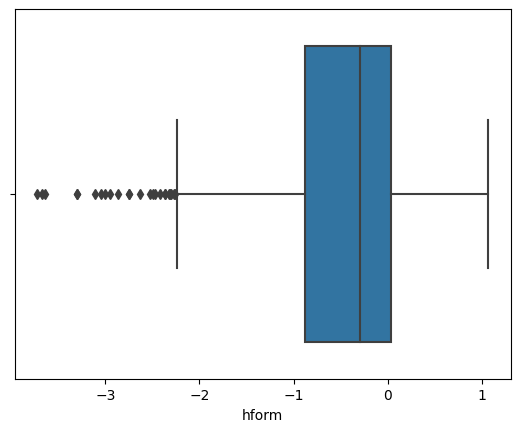

In [124]:
_ = sns.boxplot(x=y_train)

In [125]:
# Removendo os outliers

X_train['target'] = y_train
q3 = np.percentile(y_train,75)
q1 =np.percentile(y_train,25)
dq = q3-q1
    
    
lim_inf = q1 - (1.5*dq)


idx = X_train.query(f'target < {lim_inf}').index
X_train = X_train.drop(idx)
y_train = X_train['target']
X_train = X_train.drop('target',axis=1)
X_train.shape

(467, 35)

A remoção dos outliers fez diminuir o RMSE.

Aqui devemos levar em consideração que o RMSE representa um erro médio, portanto, seria muito mais interessante analisarmos a distribuição do erro a apenas tomar decisões em cima de valores médios.

Antes de nos aprofundarmos, eu gostaria de adicionar novas features ao conjunto de dados.

In [126]:
validacao_cruzada(modelos,X_train,y_train)

----- linear ----
	-> Rms em cada fold: [0.32337856 0.31453913 0.32712213 0.39646212 0.37295567]

----- lasso ----
	-> Rms em cada fold: [0.69249191 0.63397689 0.64068299 0.59527453 0.60336859]

----- ridge ----
	-> Rms em cada fold: [0.33198935 0.31630043 0.32696054 0.39325383 0.36841967]



,modelos,media,std
linear,linear,0.346892,0.032022
lasso,lasso,0.633159,0.034352
ridge,ridge,0.347385,0.028868


## **Adicionando novas features**

Preenchendo os valores faltantes com zero

In [127]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

Estabelecendo novas features com o PolynomialFeatures

In [128]:
poly = PolynomialFeatures(degree=2,include_bias=False)
poly.set_output(transform='pandas')

X_featured = poly.fit_transform(X_train.drop('Space Group',axis=1))
X_featured['Space Group'] = X_train['Space Group']

X_test_featured= poly.transform(X_test.drop('Space Group',axis=1))
X_test_featured['Space Group'] = X_test['Space Group']

Há agora 630 features

In [129]:
X_featured.shape

(467, 630)

Notamos que os rmse's ainda estão altos. E pior, adicionar novas features fez com que o modelo linear piorasse seu poder preditivo. Por outro lado, observamos uma pequena melhora nas estimativas do Ridge.

In [130]:
modelos = init_model(alpha_lasso = 1e-3, alpha_ridge = 1, x_train= X_featured, imputer=imputer, encoder=encoder, scaler=scaler)
validacao_cruzada(modelos,X_featured,y_train)

----- linear ----
	-> Rms em cada fold: [0.88076585 0.77577323 0.54206017 1.97294995 1.13384313]

----- lasso ----
	-> Rms em cada fold: [0.21232502 0.20131535 0.21946368 0.33976731 0.27246463]

----- ridge ----
	-> Rms em cada fold: [0.22334073 0.19328785 0.22226752 0.41148702 0.27610237]



,modelos,media,std
linear,linear,1.061078,0.493983
lasso,lasso,0.249067,0.051537
ridge,ridge,0.265297,0.077827


**Treinando em todo o conjunto de treinamento e avaliando com  o conjunto de teste**

O modelo linear sofreu overfitting e isso provavelmente ocorreu devido a alta dimensionalidade envolvida.

Por outro lado, os modelos com regularização não overfittaram e apresentaram resultados interessantes.

In [131]:
treinar(modelos, X_featured,y_train,X_test_featured,y_test)

----- linear ----
----- lasso ----
----- ridge ----


,modelos,rmse_treino,rmse_teste,mae_treino,mae_teste
linear,linear,0.123060,2.010179e+10,0.091706,3.768894e+09
lasso,lasso,0.177327,2.606686e-01,0.132457,1.819632e-01
ridge,ridge,0.151170,2.484172e-01,0.112678,1.617319e-01


In [132]:
colunas = X_featured.columns.to_frame(name='feature').reset_index(drop=True)
colunas['ridge_importance'] = np.abs(modelos['ridge'][-1].coef_)
colunas['lasso_importance'] = np.abs(modelos['lasso'][-1].coef_)
colunas['linear_importance'] = np.abs(modelos['linear'][-1].coef_)

As 20 features mais importantes segundo o modelo Ridge estão listadas a seguir.

Notamos que apenas a variável Z_x estava presente no dataset original, sendo todas as demais provenientes do PolynomialFeatures.

In [133]:
colunas.sort_values(by='ridge_importance',ascending=False)[['feature','ridge_importance']][:20]

,feature,ridge_importance
457,NumberUnfilledOrbitals_x Polarizability_y,0.491333
0,Z_x,0.469701
438,PeriodicColumn_upto18_x Polarizability_y,0.365025
445,NumberUnfilledOrbitals_x HOMO_y,0.354589
452,NumberUnfilledOrbitals_x r_covalent_y,0.269388
132,IonizationPotential_x Polarizability_y,0.234737
537,ElectronAffinity_y Polarizability_y,0.201842
460,Polarizability_x Electronegativity_y,0.184466
449,NumberUnfilledOrbitals_x r_d_orbital_y,0.184172
443,NumberUnfilledOrbitals_x IonizationPotential_y,0.182871


As 20 features mais importantes segundo o modelo Lasso estão listadas a seguir.

E novamente só a feature Z_x apareceu no top 20

In [134]:
colunas.sort_values(by='lasso_importance',ascending=False)[['feature','lasso_importance']][:20]

,feature,lasso_importance
457,NumberUnfilledOrbitals_x Polarizability_y,0.516261
452,NumberUnfilledOrbitals_x r_covalent_y,0.511999
0,Z_x,0.457058
537,ElectronAffinity_y Polarizability_y,0.381519
438,PeriodicColumn_upto18_x Polarizability_y,0.355458
462,Polarizability_x ElectronAffinity_y,0.308159
171,HOMO_x r_covalent_x,0.283926
352,r_valence_lastorbital_x Polarizability_y,0.242582
443,NumberUnfilledOrbitals_x IonizationPotential_y,0.216628
82,Electronegativity_x NumberUnfilledOrbitals_x,0.214046


Além disso, notamos que um total de 630 features o Lasso zerou os coeficientes de 467 delas.

In [135]:
X_featured.shape

(467, 630)

Para simplificar o modelo nós até poderíamos remover algumas variáveis, mas nesse contexto eu não sei se tem sentido fazermos isso. 

1. Os próprios modelos tendem a desconsiderar às features com os coeficientes zerados (lasso) ou próximos de zero (ridge). Portanto, remove-los agora não resultaria em nenhum ganho para o modelo a não ser na simplificação do dataset.

2. Não fica claro qual deveria ser o limiar que deveríamos considerar para eliminar uma feature ao analisarmos os coeficientes de ambos os modelos visto que todos os coeficientes (não zerados) tem valores razoáveis.

## Avaliação dos erros

Para finalizar essa atividade vamos analisar estatisticamente as predições finais realizadas pelo Lasso e Ridge

In [136]:
y_pred_lasso = modelos['lasso'].predict(X_test_featured)
y_pred_ridge = modelos['ridge'].predict(X_test_featured)

X_test['real'] = y_test
X_test['lasso_pred'] = y_pred_lasso
X_test['ridge_pred'] = y_pred_ridge

val = X_test[['real','lasso_pred','ridge_pred']]

Calculando o erro percentual entre as estimativas

$E(\%) = \dfrac{|real-pred|}{real} \cdot 100$

In [137]:
val['err_lasso'] = val['real'] - val['lasso_pred']
val['err_ridge'] = val['real'] - val['ridge_pred']

val['err_percent_lasso'] = np.abs(val['err_lasso']/val['real'] *100)
val['err_percent_ridge'] = np.abs(val['err_ridge']/val['real'] *100)

Do gráfico abaixo é perceptível que uma instância dos dados está bem distante das demais estimativas. Agora fica claro um dos motivos do erro ter sido alto, essa instância penalizou bastante as nossas métricas. 

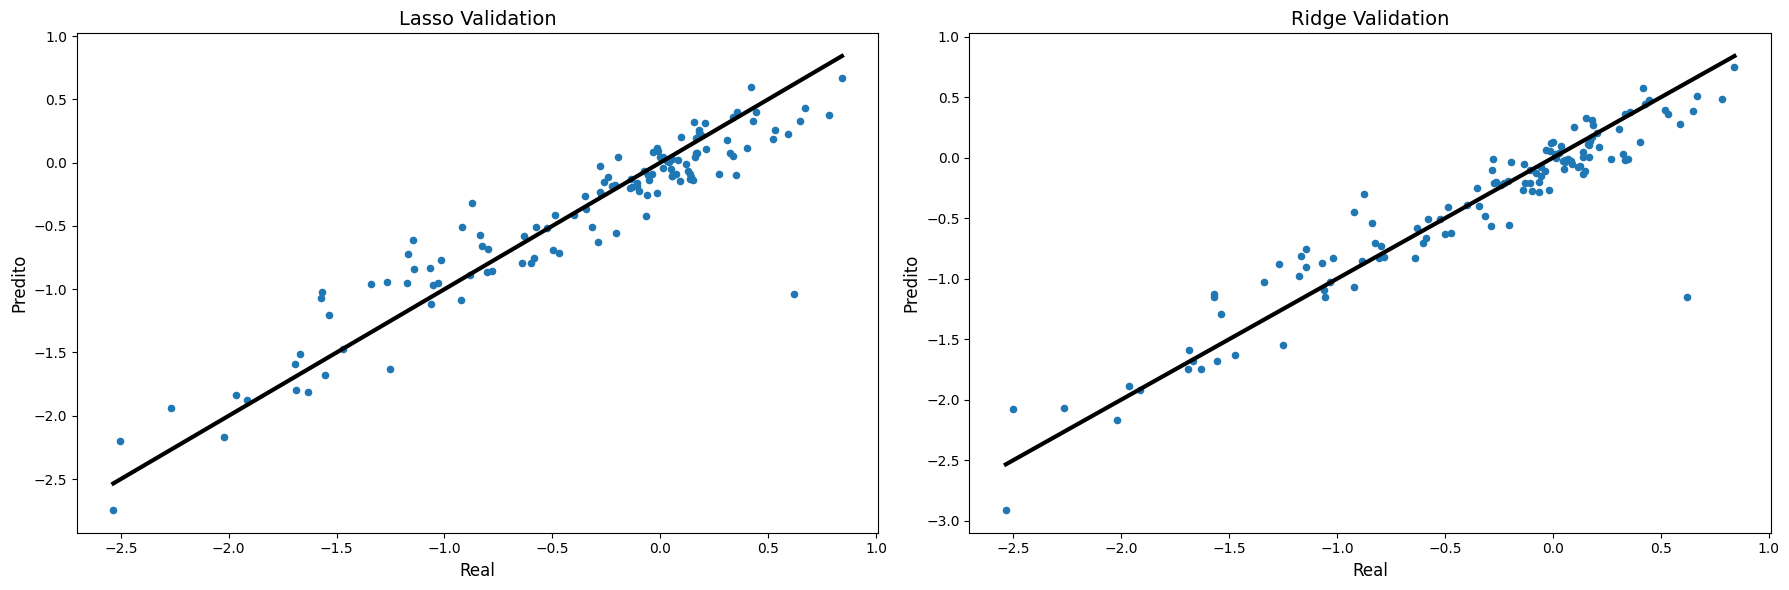

In [138]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].scatter(val['real'],val['lasso_pred'],s=20)
ax[0].plot([val['real'].min(),val['real'].max()],[val['real'].min(),val['real'].max()],linewidth=3,c='black')
ax[0].set_title('Lasso Validation',size = 14)
ax[0].set_xlabel('Real',size=12)
ax[0].set_ylabel('Predito',size=12) 

ax[1].scatter(val['real'],val['ridge_pred'],s=20)
ax[1].plot([val['real'].min(),val['real'].max()],[val['real'].min(),val['real'].max()],linewidth=3,c='black')
ax[1].set_title('Ridge Validation',size = 14)
ax[1].set_xlabel('Real',size=12)
ax[1].set_ylabel('Predito',size=12); 
plt.tight_layout()

Na tabela abaixo são exibidas as métricas de treino e teste,  apresentamos também o rms e o mae corrigido, onde nessa correção desconsideramos a instância problemática.

Note que após a correção as métricas ficaram muito mais próximas. Entretanto, isso já é o esperado, pois do gráfico acima a maioria dos valores se encontram ao redor da reta de predição perfeita.

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;}
.tg td{background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-wp8o{border-color:#000000;text-align:center;vertical-align:top}
.tg .tg-mqa1{border-color:#000000;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-mcqj{border-color:#000000;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-jbyd{background-color:#ffffff;border-color:#000000;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-mqa1">Modelo</th>
    <th class="tg-mqa1">rmse treino</th>
    <th class="tg-mqa1">rmse teste</th>
    <th class="tg-mqa1">mae treino</th>
    <th class="tg-mqa1">mae teste</th>
    <th class="tg-mcqj">rmse corrigido</th>
    <th class="tg-mcqj">mae corrigido</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-mqa1">Lasso</td>
    <td class="tg-wp8o">0.18</td>
    <td class="tg-wp8o">0.26</td>
    <td class="tg-wp8o">0.13</td>
    <td class="tg-wp8o">0.18</td>
    <td class="tg-jbyd">0.21</td>
    <td class="tg-wp8o">0.16</td>
  </tr>
  <tr>
    <td class="tg-mqa1">Ridge</td>
    <td class="tg-wp8o">0.15</td>
    <td class="tg-wp8o">0.24</td>
    <td class="tg-wp8o">0.11</td>
    <td class="tg-wp8o">0.16</td>
    <td class="tg-jbyd"><span style="font-weight:400;font-style:normal">0.19</span></td>
    <td class="tg-wp8o"><span style="font-weight:400;font-style:normal">0.15</span></td>
  </tr>
</tbody>
</table>


Segue a instância problemática

In [139]:
X_test.loc[val.query('err_lasso > 1').index,:]

,Space Group,Z_x,Electronegativity_x,IonizationPotential_x,ElectronAffinity_x,HOMO_x,LUMO_x,r_s_orbital_x,r_p_orbital_x,r_d_orbital_x,...,r_valence_lastorbital_y,r_covalent_y,Valence_y,PeriodicColumn_y,PeriodicColumn_upto18_y,NumberUnfilledOrbitals_y,Polarizability_y,real,lasso_pred,ridge_pred
544,P-4m2,55,0.79,-3.8463,-0.5091,-2.0859,-0.2279,2.5357,2.7555,1.8065,...,0.4333,0.66,6.0,6.0,16.0,2.0,5.24,0.620531,-1.03779,-1.151937


In [140]:
val = val.drop(val.query('err_lasso > 1').index)

In [141]:
print(mean_squared_error(val['real'],val['lasso_pred'],squared=False), 
mean_absolute_error(val['real'],val['lasso_pred']),
mean_squared_error(val['real'],val['ridge_pred'],squared=False), 
mean_absolute_error(val['real'],val['ridge_pred']))

0.21439182980192317 0.16986187487810234 0.19096017314170297 0.14852909557602187


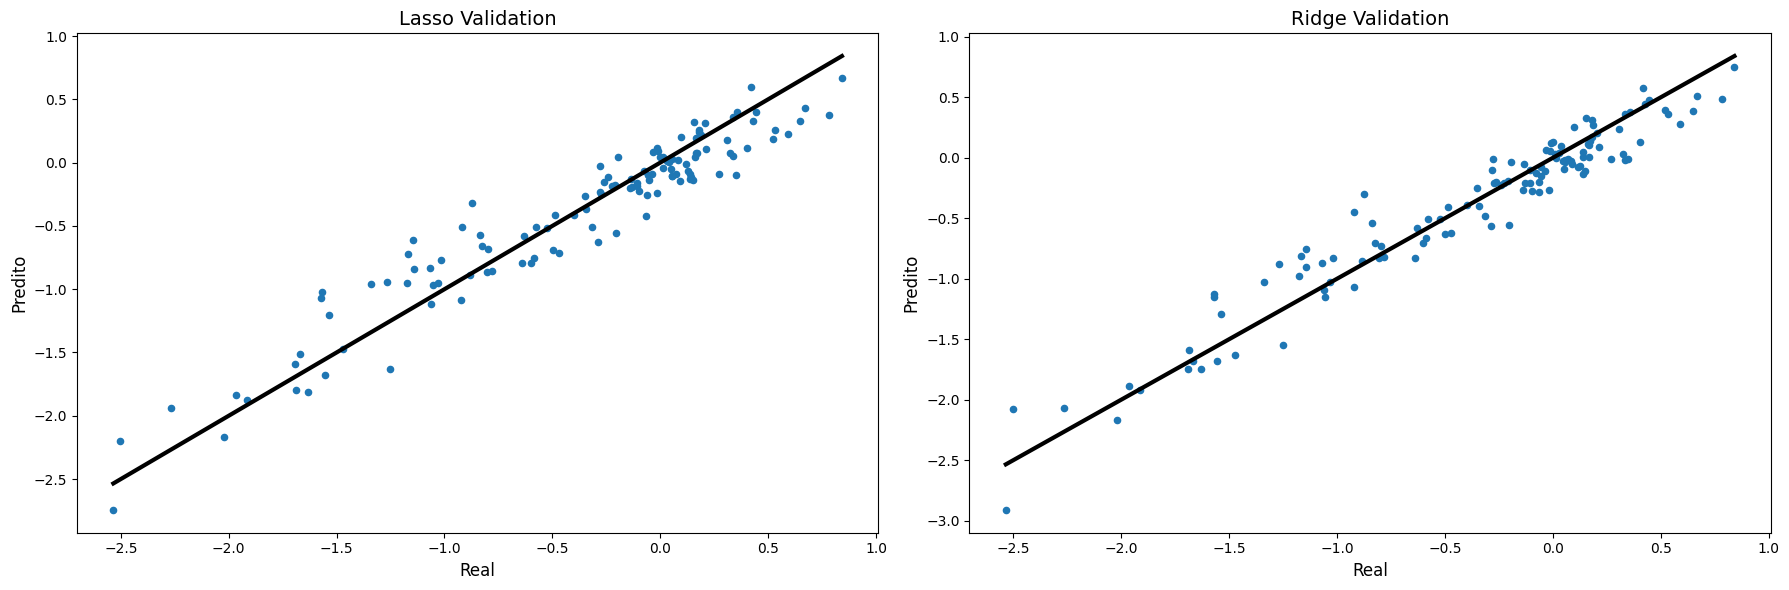

In [142]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].scatter(val['real'],val['lasso_pred'],s=20)
ax[0].plot([val['real'].min(),val['real'].max()],[val['real'].min(),val['real'].max()],linewidth=3,c='black')
ax[0].set_title('Lasso Validation',size = 14)
ax[0].set_xlabel('Real',size=12)
ax[0].set_ylabel('Predito',size=12) 

ax[1].scatter(val['real'],val['ridge_pred'],s=20)
ax[1].plot([val['real'].min(),val['real'].max()],[val['real'].min(),val['real'].max()],linewidth=3,c='black')
ax[1].set_title('Ridge Validation',size = 14)
ax[1].set_xlabel('Real',size=12)
ax[1].set_ylabel('Predito',size=12); 
plt.tight_layout()

Observamos que para o Lasso 80% dos erros se encontram abaixo de 0.28. 

Para o Ridge, 80% dos erros se encontram abaixo de 0.26.

---> Obs: Erros em valores absolutos

In [143]:
np.percentile(np.abs(val['err_lasso']),80), np.percentile(np.abs(val['err_ridge']),80)

(0.27878054610409264, 0.25615168821898693)

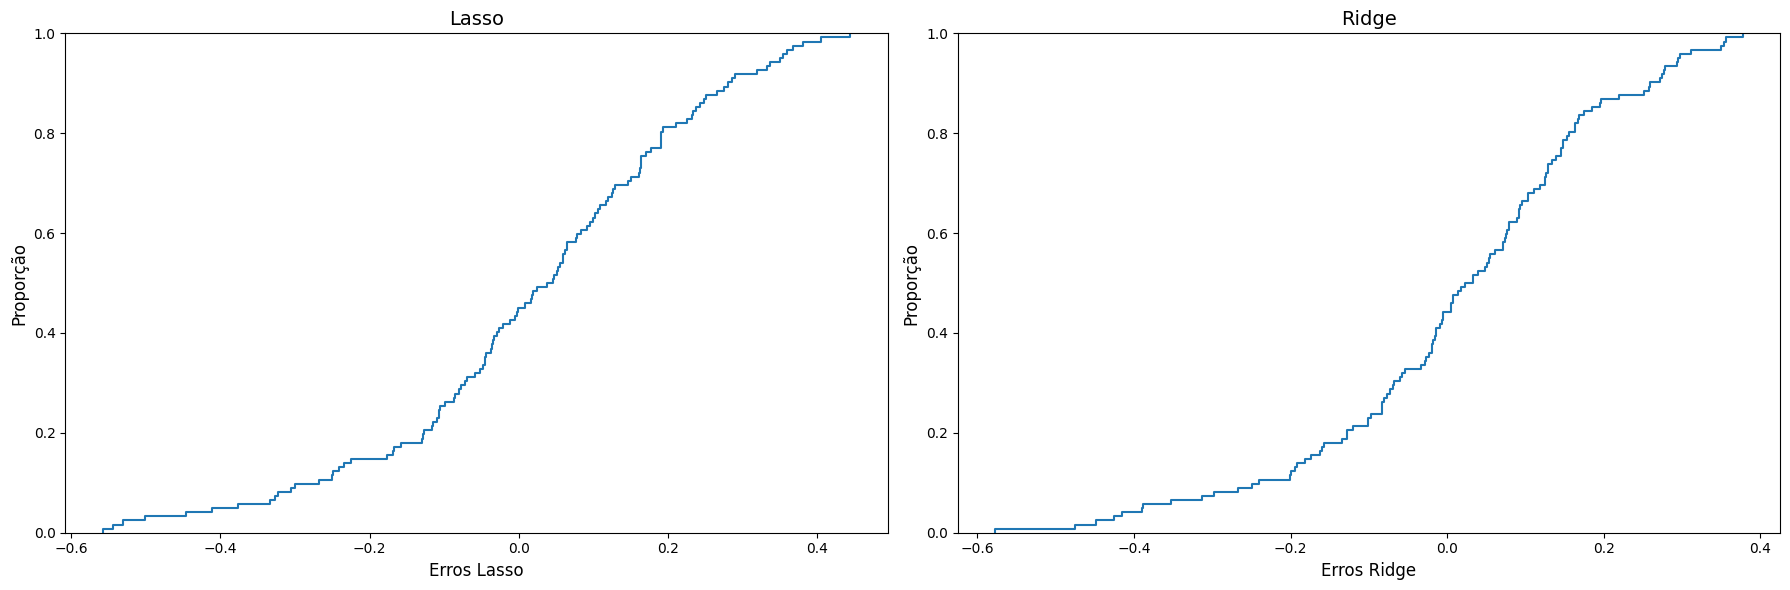

In [144]:
fig,ax = plt.subplots(1,2,figsize=(18,6))


sns.ecdfplot(data=val, x='err_lasso',ax=ax[0])
ax[0].set_xlabel("Erros Lasso",size=12)
ax[0].set_ylabel("Proporção",size=12)
ax[0].set_title("Lasso",size=14)

sns.ecdfplot(data=val,x='err_ridge',ax=ax[1]);
ax[1].set_xlabel("Erros Ridge",size=12)
ax[1].set_ylabel("Proporção",size=12)
ax[1].set_title("Ridge",size=14)


plt.tight_layout()

Observamos uma moderada correlação linear ao analisarmos os coeficientes de pearson com relação aos erros e os valores reais da energia de formação.

In [145]:
val.corr()['real'].sort_values(ascending=False)

real                 1.000000
ridge_pred           0.966482
lasso_pred           0.958793
err_lasso            0.486759
err_ridge            0.399756
err_percent_lasso    0.050761
err_percent_ridge    0.048842
Name: real, dtype: float64

Dos gráficos a seguir é possível observar uma tendencia linear dos erros comparados a energia de formação no dataset de teste.

Além disso, observamos que os erros de ambos os modelos seguem uma distribuição assimétrica a esquerda.

O padrão esperado por mim consiste em um erro com distribuição gaussiana com uma média próxima a zero.

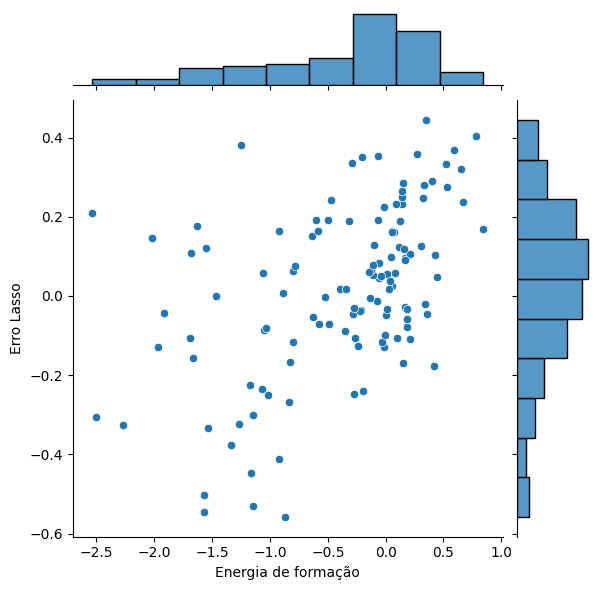

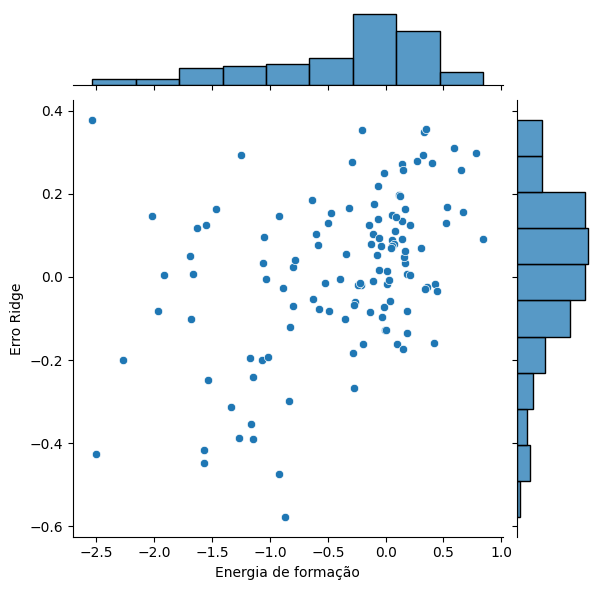

In [146]:
sns.jointplot(data=val,x='real',y='err_lasso')
plt.xlabel('Energia de formação')
plt.ylabel('Erro Lasso')
sns.jointplot(data=val,x='real',y='err_ridge')
plt.xlabel('Energia de formação')
plt.ylabel('Erro Ridge');

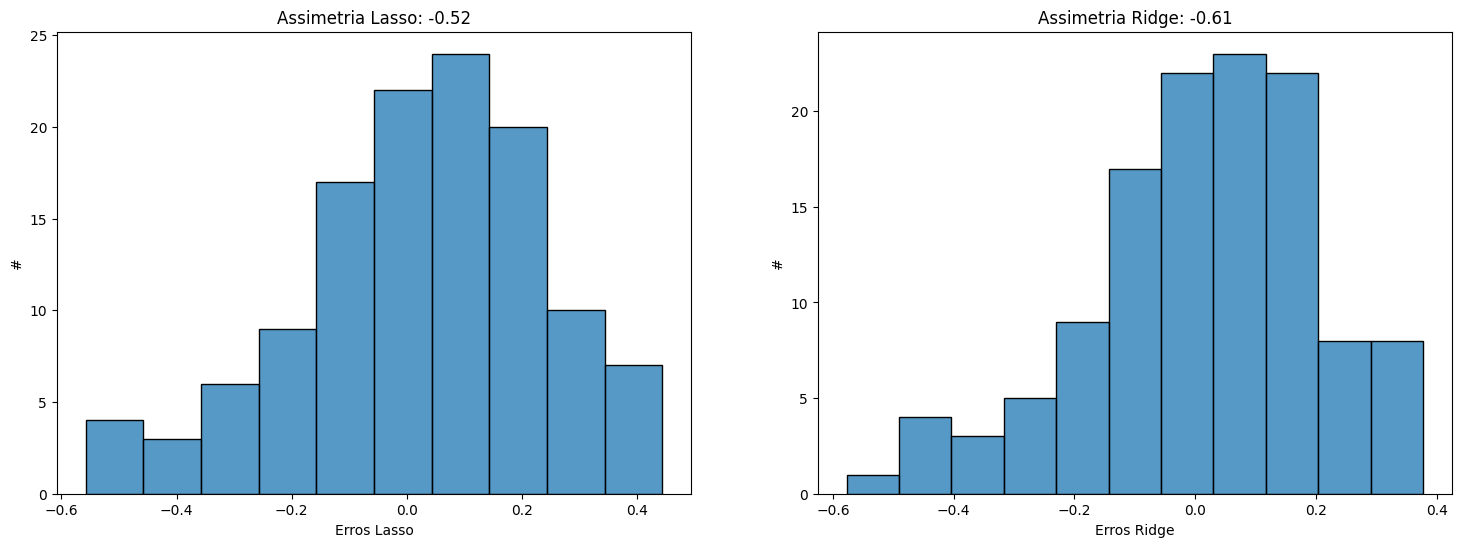

In [147]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

sns.histplot(data=val,x='err_lasso',ax=ax[0])
ax[0].set_xlabel('Erros Lasso')
ax[0].set_ylabel("#")
sns.histplot(data=val,x='err_ridge',ax=ax[1])
ax[1].set_xlabel('Erros Ridge')
ax[1].set_ylabel("#")

ax[0].set_title(f"Assimetria Lasso: {val['err_lasso'].skew():.2f}")
ax[1].set_title(f"Assimetria Ridge: {val['err_ridge'].skew():.2f}");

A seguir, podemos observar a distribuição dos dados preditos e dos dados reais. É perceptível a diferença entre os preditos com os reais, principalmente no intervalo de 0 a -2. Isso sugere que podemos tentar trabalhar melhor a nossa base de dados ou até mesmo incluir modelos mais complexos para obtermos melhores resultados.

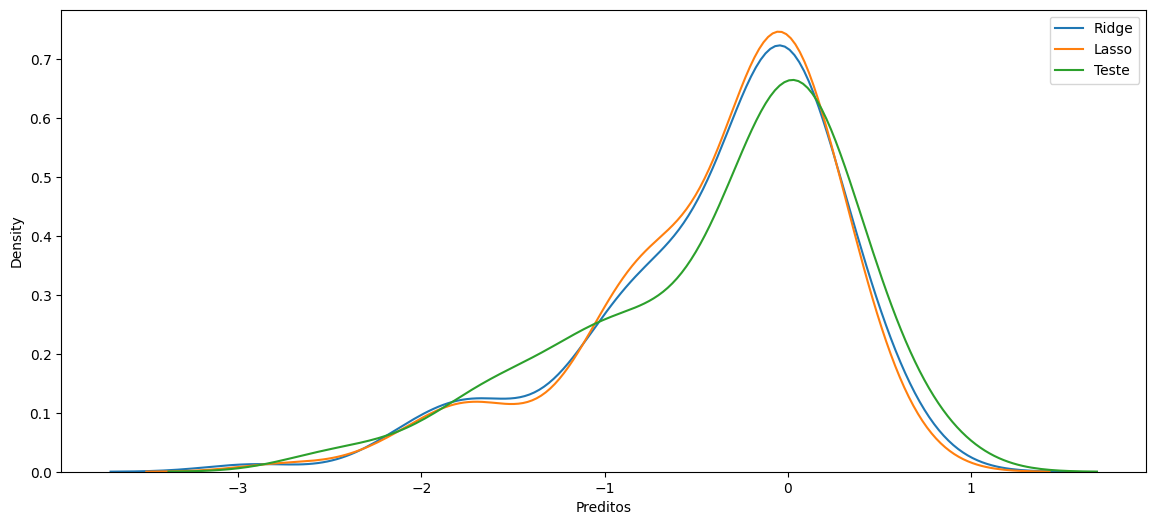

In [148]:
plt.figure(figsize=(14,6))
sns.kdeplot(data=val,x='ridge_pred',label='Ridge')
sns.kdeplot(data=val,x='lasso_pred',label='Lasso')
sns.kdeplot(data=val,x='real',label='Teste')
plt.xlabel('Preditos')
plt.legend();

Ao compararmos as distribuições de treino e teste observamos uma diferença. Reparamos também como a distribuição de treino se assemelha muito mais a distribuição real do dataset antes do split.

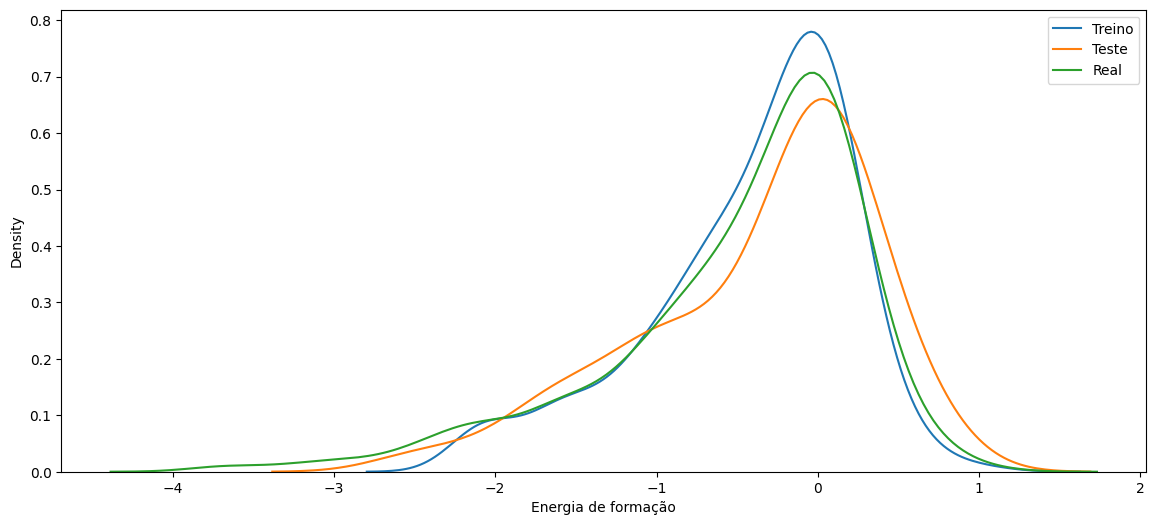

In [149]:
plt.figure(figsize=(14,6))
sns.kdeplot(x=y_train,label='Treino')
sns.kdeplot(x=y_test,label='Teste')
sns.kdeplot(data=data, x='hform',label='Real')
plt.xlabel('Energia de formação')
plt.legend();

Comparando as predições com os valores de treinamento nós observamos uma aproximação maior entre as três distribuições.

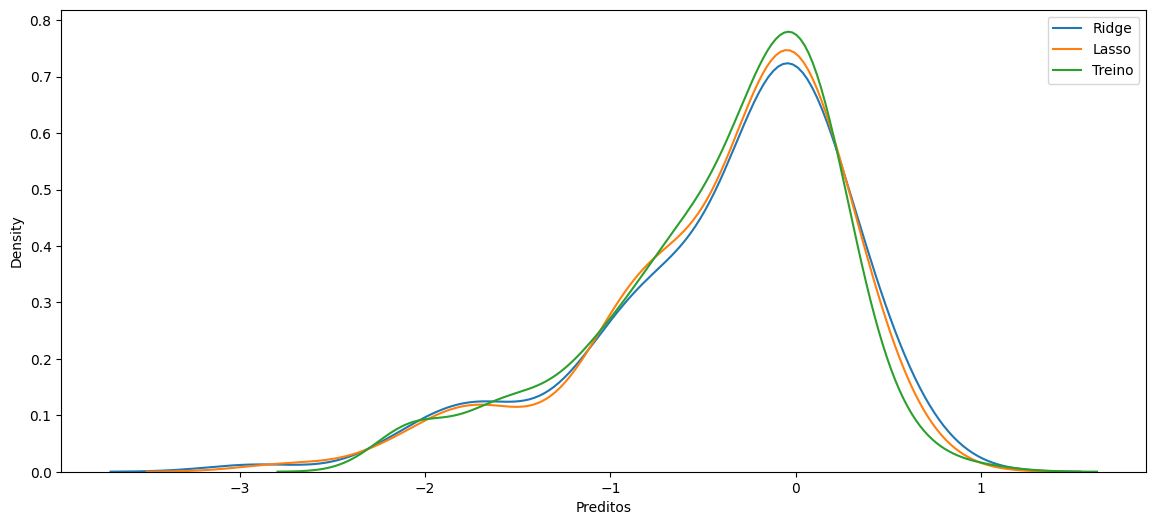

In [150]:
plt.figure(figsize=(14,6))
sns.kdeplot(data=val,x='ridge_pred',label='Ridge')
sns.kdeplot(data=val,x='lasso_pred',label='Lasso')
sns.kdeplot(x=y_train,label='Treino')
plt.xlabel('Preditos')
plt.legend();

> * Observamos que existem distinções entre a distribuição de treino quando comparada a distribuição de teste. Muito provavelmente essa ligeira diferença entre as distribuições afeta o poder preditivo dos nossos modelos.

> * Logo, as duvidas residem acerca da diferença entre essas distribuições. O que poderíamos fazer para deixa-las mais similares? 

> * Talvez a resposta para essa pergunta seja aumentar o conjunto de teste, fazendo isso apenas alterando a proporção do split no train_test_split ou até mesmo obtendo novos dados.

Para não me estender vou finalizar a atividade por aqui. Entretanto, poderíamos testar muitas outras abordagens, como treinar modelos mais robustos e analisar mais afundo os erros para tentarmos encontrar algum padrão não localizado.